## 기본설정 및 함수정의

In [52]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from folium.plugins import HeatMapWithTime
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import unary_union
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
from keplergl import KeplerGl
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

# tqdm의 pandas전용 메소드를 호출
tqdm.pandas()
# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)
 
# Point를만드는 함수
def make_point(x):
    try:
        return Point(x)
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])
    
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.progress_apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

##### 격자

In [3]:
# GeoJSON 파일 불러오기
with open('SBJ_2411_001/2-14.하남시_격자.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df = pd.json_normalize(geojson_data['features'])
grid_map_df['geometry'] = grid_map_df['geometry.coordinates'].apply(lambda x : make_pol(x))
grid_map_df.drop(columns="geometry.coordinates", axis=1, inplace=True)
grid_map_df = grid_map_df[~grid_map_df['properties.gid'].str.startswith('다아')]
# grid_map_df 데이터프레임을 GeoDataFrame으로 변환
grid_map_df = gpd.GeoDataFrame(grid_map_df, geometry='geometry')

##### 행정동

In [4]:
# 하남시 행정동 데이터
shapefile_path1 = "SBJ_2411_001/bnd_dong_31180_2023_2Q/bnd_dong_31180_2023_2Q.shp"
hanam_gdf = gpd.read_file(shapefile_path1)
hanam_gdf = hanam_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

# 화성시 행정동 데이터
shapefile_path2 = "SBJ_2411_001/bnd_dong_31240_2023_2Q/bnd_dong_31240_2023_2Q.shp"
hwasung_gdf = gpd.read_file(shapefile_path2)
hwasung_gdf = hwasung_gdf.to_crs(epsg=4326) #EPSG4326 형식으로 변환

#### 격자(매핑용)

In [5]:
# GeoJSON 파일 불러오기
with open('SBJ_2411_001/1-14.화성시_격자.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df = pd.json_normalize(geojson_data['features'])
grid_map_df['geometry'] = grid_map_df['geometry.coordinates'].apply(lambda x : make_pol(x))
grid_map_df.drop(columns="geometry.coordinates", axis=1, inplace=True)
grid_map_df = grid_map_df[~grid_map_df['properties.gid'].str.startswith('다아')]
# grid_map_df 데이터프레임을 GeoDataFrame으로 변환
grid_map_df = gpd.GeoDataFrame(grid_map_df, geometry='geometry')
grid_dict = dict(zip(grid_map_df['properties.gid'], grid_map_df['geometry']))

In [ ]:
# 맵 객체 생성 및 데이터 로드
hwasung_map = KeplerGl(height=1000, width=1500)
hwasung_map.add_data(data=grid_map_df, name="격자 데이터")

# 맵 출력 및 상세설정
hwasung_map

In [22]:
# 맵 저장
hwasung_map.save_to_html(file_name="visualization/화성시 현황/화성시 격자 map.html")

Map saved to visualization/화성시 현황/화성시 격자 map.html!


#### 격자인구통계

In [6]:
respop_df = pd.read_csv('SBJ_2411_001/1-1.화성시_거주인구.csv')

#grid ID 리스트 와 매핑 & respop_df 필터링
grid_id = grid_map_df['properties.gid'].tolist() # gid는 전부 unique한 값
grid_respop = respop_df[respop_df['gid'].isin(grid_id)]
grid_respop = grid_respop.fillna(0)
grid_respop = pd.concat([grid_respop.iloc[:, :2], grid_respop.iloc[:, 2:].astype(int)], axis=1)
grid_respop['year'] = grid_respop['year'].astype(str)

# 성별구분 없이 통합 및 세대별 인구수 데이터프레임으로 변환
columns = ['gid', 'year']
for i in range(2, len(grid_respop.columns)):
    age = f'{grid_respop.columns[i][2:4]}대' if grid_respop.columns[i][2] != '1' else f'{grid_respop.columns[i][2:5]}대'
    sex = '남' if grid_respop.columns[i][0] != 'm' else '여'
    columns.append('%s_%s'%(age, sex))
grid_respop.columns = columns
# 인구 column & 고령인구 column & 고령인구 비율(%) column 생성
grid_respop['인구'] = grid_respop.iloc[:, 2:].sum(axis=1)

In [7]:
# 연령대별로 성별 통합
grid_respop['20대'] = grid_respop['20대_여'] + grid_respop['20대_남']
grid_respop['30대'] = grid_respop['30대_여'] + grid_respop['30대_남']
grid_respop['40대'] = grid_respop['40대_여'] + grid_respop['40대_남']
grid_respop['50대'] = grid_respop['50대_여'] + grid_respop['50대_남']
grid_respop['60대'] = grid_respop['60대_여'] + grid_respop['60대_남']
grid_respop['70대'] = grid_respop['70대_여'] + grid_respop['70대_남']
grid_respop['80대'] = grid_respop['80대_여'] + grid_respop['80대_남']
grid_respop['90대'] = grid_respop['90대_여'] + grid_respop['90대_남']
grid_respop['100대'] = grid_respop['100대_여'] + grid_respop['100대_남']

# 필요한 열만 선택
age_totals = grid_respop[['year', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대', '100대']]

# 데이터프레임을 긴 형식으로 변환
age_totals_melted = age_totals.melt(id_vars='year', var_name='Age Group', value_name='Count')

# 연도별 연령대 분포 계산
age_totals_yearly = age_totals_melted[['Age Group', 'Count']].groupby(['Age Group']).sum().reset_index()
# 100대 연령대 제거
age_totals_yearly = age_totals_yearly[age_totals_yearly['Age Group'] != '100대']

# 연령대 종합 평균내기
age_totals_yearly['Count'] = age_totals_yearly['Count'] / 4
age_totals_yearly['Count'] = age_totals_yearly['Count'].astype(int)
# 시각화
fig = px.bar(
    age_totals_yearly,
    x='Age Group',
    y='Count',
    color='Count',
    color_continuous_scale='Plasma_r',  # Plasma 색상 맵 사용
    labels={'year': 'Year', 'Count': 'Population Count', 'Age Group': 'Age Group'},
)
fig.update_layout(height=600, width=1200)
fig.show()

In [8]:
gen_respop = grid_respop[['gid', '20대', '30대', '40대', '50대', '60대', '70대', '80대', '90대', '100대', '인구']]
gen_respop = gen_respop.groupby('gid').sum().reset_index()

# 격자 ID와 격자 폴리곤 각각을 매핑한 딕셔너리 생성
map_dic = dict(zip(grid_map_df['properties.gid'], grid_map_df['geometry']))

# 생성된 map_dic에 filtered_respop의 gid를 매핑하여 'geometry' column 생성
geometry_lst = []
for _, row in gen_respop.iterrows():
    geometry_lst.append(map_dic[row['gid']])
gen_respop['geometry'] = geometry_lst
gen_respop = gpd.GeoDataFrame(gen_respop, geometry='geometry')

In [ ]:
# 맵 객체 생성 및 데이터 로드
hwasung_gridgenpop_map = KeplerGl(height=1000, width=1500)
hwasung_gridgenpop_map.add_data(data=gen_respop, name="화성시 격자거주인구 데이터")

# 맵 출력 및 상세설정
hwasung_gridgenpop_map

In [24]:
# 맵 저장
hwasung_gridgenpop_map.save_to_html(file_name="visualization/화성시 현황/화성시 격자거주인구 map.html")

Map saved to visualization/화성시 현황/화성시 격자거주인구 map.html!


In [9]:
age_totals_gen = age_totals.groupby('year').sum().reset_index()
# 각 세대별 총 인구수 계산 및 정렬
total_pop = age_totals_gen.drop(columns='year').sum().sort_values(ascending=False)
sorted_columns = total_pop.index.tolist()

# 각 세대별로 데이터를 분리하여 선과 마커를 동시에 표시하는 그래프 생성
fig = go.Figure()

for column in sorted_columns:  # 'year' 열을 제외한 각 세대별 열에 대해 반복
    fig.add_trace(go.Scatter(
        x=age_totals_gen['year'], 
        y=age_totals_gen[column], 
        mode='lines+markers', 
        name=column
    ))
# 색상 업데이트
colors =px.colors.sequential.Plasma # 컬러맵
for i, trace in enumerate(fig.data):
    trace.line.color = colors[i % len(colors)]
# 그래프 레이아웃 설정
fig.update_layout(
    xaxis_title='Year',
    yaxis_title='Population',
    width=800,
    height=600
)

# 그래프 시각화
fig.show()

#### 거주인구 성별 & 세대 구분한 데이터 생성

In [22]:
gengen_respop = grid_respop[['gid'] + list(grid_respop.columns[2:20])]
gengen_respop = gengen_respop.groupby('gid').mean().reset_index()

# 격자 ID와 격자 폴리곤 각각을 매핑한 딕셔너리 생성
map_dic = dict(zip(grid_map_df['properties.gid'], grid_map_df['geometry']))

# 생성된 map_dic에 filtered_respop의 gid를 매핑하여 'geometry' column 생성
geometry_lst = []
for _, row in gengen_respop.iterrows():
    geometry_lst.append(map_dic[row['gid']])
gengen_respop['geometry'] = geometry_lst
gengen_respop = gpd.GeoDataFrame(gengen_respop, geometry='geometry')

#### 세대별 유동인구

In [24]:
# 유동인구 df 로드
floating_population_df = pd.read_csv('SBJ_2411_001/1-8.화성시_성연령별_유동인구.csv')
floating_population_df['STD_YM'] = floating_population_df['STD_YM'].astype(str)

# 성별구분 없이 통합 및 세대별 인구수 데이터프레임으로 변환
columns = ['year']
for i in range(1, 13):
    floating_population_df[floating_population_df.columns[i]] = floating_population_df[floating_population_df.columns[i]].astype(float)
    new_col = f'{floating_population_df.columns[i][2:4]}대_남' if floating_population_df.columns[i][0] != 'm' else f'{floating_population_df.columns[i][2:4]}대_여'
    columns.append(new_col)
floating_population_df.columns = columns + floating_population_df.columns[13:15].tolist()
floating_population_df['총합'] = floating_population_df.iloc[:, 1:-3].sum(axis=1)
floating_population_df['year'] = floating_population_df['year'].apply(lambda x : x[2:])
floating_population_df = geo_transform(floating_population_df)

col_lst = ['year'] + list(floating_population_df.columns[-1:]) + list(floating_population_df.columns[1:13]) + ['총합']
floating_population_df = floating_population_df[col_lst]

merged_gdf = gpd.sjoin(floating_population_df, grid_map_df, how='inner', op='within')

merged_gdf['year'] = "20" + merged_gdf['year'].astype(str).str[:2]
merged_gdf['year'] = merged_gdf['year'].astype(int)

aggregated_data = merged_gdf.groupby(['year', 'properties.gid'], as_index=False).agg({
    '10대_여': 'sum',
    '20대_여': 'sum',
    '30대_여': 'sum',
    '40대_여': 'sum',
    '50대_여': 'sum',
    '60대_여': 'sum',
    '10대_남': 'sum',
    '20대_남': 'sum',
    '30대_남': 'sum',
    '40대_남': 'sum',
    '50대_남': 'sum',
    '60대_남': 'sum',
    '총합': 'sum',
})
aggregated_data['geometry'] = aggregated_data['properties.gid'].map(grid_dict)
aggregated_data = gpd.GeoDataFrame(aggregated_data, geometry='geometry')

100%|██████████| 5269124/5269124 [03:14<00:00, 27116.36it/s]
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\user\AppData\Local\Te

In [25]:
from sklearn.tree import DecisionTreeRegressor

# 결과를 저장할 리스트 초기화
filled_rows = []

# properties.gid별로 데이터 그룹화
for gid, group in tqdm(aggregated_data.groupby('properties.gid')):
    group = group.sort_values(by='year')  # 연도 정렬
    full_years = np.arange(2020, 2024)  # 2020~2023 연도 생성

    # 입력 변수 (X: 기존 연도), 출력 변수 (y: 나머지 데이터)
    X = group[['year']].values
    y = group[['10대_여', '20대_여', '30대_여', '40대_여', '50대_여', '60대_여',
               '10대_남', '20대_남', '30대_남', '40대_남', '50대_남', '60대_남', '총합']].values

    # Decision Tree Regressor 초기화
    model = DecisionTreeRegressor(random_state=42)

    # 다중 출력 예측을 위한 컬럼별 개별 학습
    y_pred_group = []
    for col_idx in range(y.shape[1]):
        model.fit(X, y[:, col_idx])  # 각 열에 대해 개별 학습
        predictions = model.predict(full_years.reshape(-1, 1))  # 2020~2023 데이터 예측
        predictions = np.maximum(predictions, 0)  # 음수값을 0으로 치환
        y_pred_group.append(predictions)

    # 예측 결과 결합
    y_pred_group = np.column_stack(y_pred_group)

    # 기존 데이터와 예측된 데이터를 결합하여 누락된 연도 채우기
    pred_df = pd.DataFrame(y_pred_group, columns=['10대_여', '20대_여', '30대_여', '40대_여', '50대_여', '60대_여',
                                                  '10대_남', '20대_남', '30대_남', '40대_남', '50대_남', '60대_남', '총합'])
    pred_df['year'] = full_years
    pred_df['properties.gid'] = gid
    pred_df['geometry'] = group['geometry'].iloc[0]  # geometry 값 복사

    # 결과 저장
    filled_rows.append(pred_df)

# 모든 결과를 하나의 데이터프레임으로 결합
filled_data = pd.concat(filled_rows, ignore_index=True)

# 기존 데이터와 병합
complete_data = pd.concat([aggregated_data, filled_data], ignore_index=True)

# 중복 제거 및 정렬
complete_data = complete_data.drop_duplicates(subset=['year', 'properties.gid']).sort_values(by=['properties.gid', 'year'])

100%|██████████| 60086/60086 [17:50<00:00, 56.11it/s]


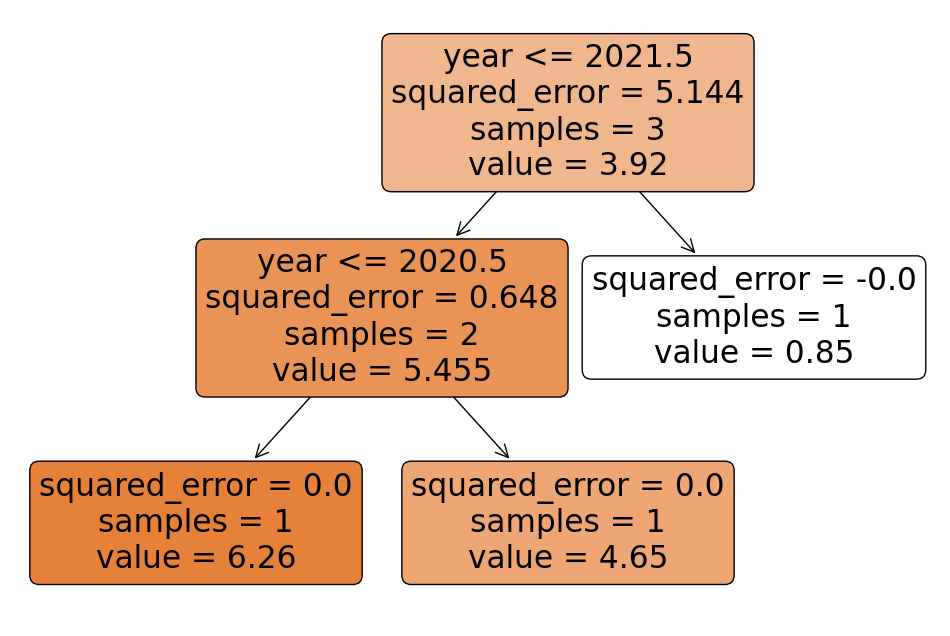

In [26]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# 특정 그룹(gid)과 특정 열(col_idx)의 트리를 시각화
gid = aggregated_data['properties.gid'].iloc[0]  # 첫 번째 gid 선택
group = aggregated_data[aggregated_data['properties.gid'] == gid].sort_values(by='year')
X = group[['year']].values
y = group[['10대_여']].values  # '10대_여' 열 선택

# Decision Tree Regressor 초기화 및 학습
model = DecisionTreeRegressor(random_state=42)
model.fit(X, y)

# 트리 시각화
plt.figure(figsize=(12, 8))
plot_tree(model, feature_names=['year'], filled=True, rounded=True)
plt.show()


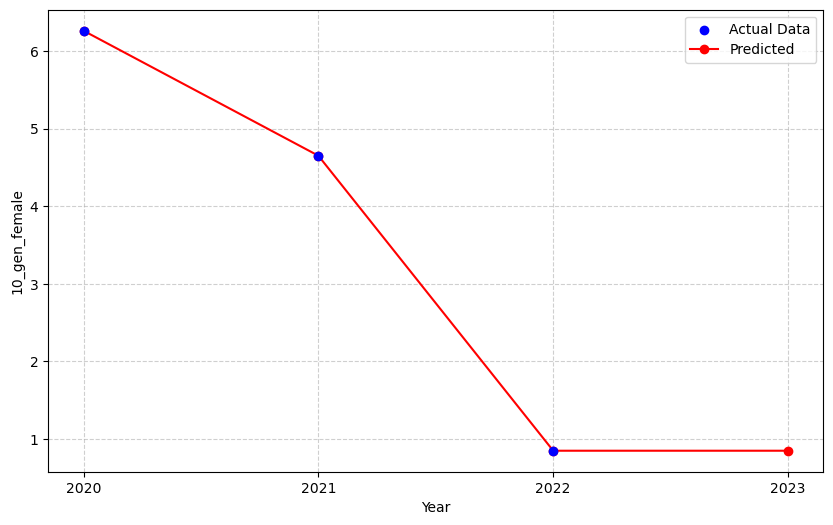

In [27]:
# data target 관계 시각화
gid = aggregated_data['properties.gid'].iloc[0]  # 첫 번째 gid 선택
group = aggregated_data[aggregated_data['properties.gid'] == gid].sort_values(by='year')
X = group[['year']].values
y = group[['10대_여']].values  # '10대_여' 열 선택

# Decision Tree Regressor 초기화 및 학습
model = DecisionTreeRegressor(random_state=42)
model.fit(X, y)

# 2020~2023 연도에 대한 예측
full_years = np.arange(2020, 2024).reshape(-1, 1)
y_pred = model.predict(full_years)

# 시각화
plt.figure(figsize=(10, 6))

# 원본 데이터 (실제 값)
plt.scatter(X, y, color='blue', label='Actual Data', zorder=3)

# 예측 데이터
plt.plot(full_years, y_pred, color='red', marker='o', linestyle='-', label='Predicted', zorder=2)

# 그래프 설정
plt.xlabel('Year')
plt.ylabel('10_gen_female')
plt.xticks(np.arange(2020, 2024))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [28]:
complete_data

,year,properties.gid,10대_여,20대_여,30대_여,40대_여,50대_여,60대_여,10대_남,20대_남,30대_남,40대_남,50대_남,60대_남,총합,geometry
164943,2020,다바145999,0.00,0.08,0.16,0.23,0.21,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.78,"POLYGON ((126.53790 37.09384, 126.53788 37.094..."
164944,2021,다바145999,0.00,0.08,0.16,0.23,0.21,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.78,"POLYGON ((126.53790 37.09384, 126.53788 37.094..."
106932,2022,다바145999,0.00,0.08,0.16,0.23,0.21,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.78,"POLYGON ((126.53790 37.09384, 126.53788 37.094..."
164946,2023,다바145999,0.00,0.08,0.16,0.23,0.21,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.78,"POLYGON ((126.53790 37.09384, 126.53788 37.094..."
164947,2020,다바154953,0.04,0.37,1.01,2.15,2.27,1.55,0.00,0.07,0.36,0.47,0.73,0.63,9.02,"POLYGON ((126.54854 37.05246, 126.54853 37.053..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405282,2023,다사699102,79.92,39.20,183.80,168.68,75.53,87.50,100.71,72.42,194.43,158.70,82.33,100.42,1243.22,"POLYGON ((127.16086 37.19010, 127.16086 37.191..."
49475,2020,다사699103,0.04,0.40,0.68,0.99,0.82,0.54,0.00,0.17,0.20,0.26,0.30,0.26,4.40,"POLYGON ((127.16086 37.19100, 127.16085 37.191..."
106931,2021,다사699103,2.38,3.82,7.88,11.42,10.54,9.57,2.96,2.76,8.03,8.48,5.44,4.80,73.28,"POLYGON ((127.16086 37.19100, 127.16085 37.191..."
164942,2022,다사699103,48.18,22.04,85.86,95.11,52.54,66.40,54.75,36.18,113.35,115.63,54.17,69.28,744.21,"POLYGON ((127.16086 37.19100, 127.16085 37.191..."


In [18]:
# 맵 객체 생성 및 데이터 로드
hwasung_floatingpop_map = KeplerGl(height=1000, width=1500)
hwasung_floatingpop_map.add_data(data=complete_data, name="유동인구 데이터")

hwasung_floatingpop_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [19]:
# 맵 저장
hwasung_floatingpop_map.save_to_html(file_name="visualization/화성시 현황/화성시 세대별 유동인구 map.html")

Map saved to visualization/화성시 현황/화성시 세대별 유동인구 map.html!


#### 공유차량 이용현황

In [136]:
sharecar_df = pd.read_csv('SBJ_2411_001/1-11.화성시_공유차량_이용현황.csv')
cols_to_exclude = ['car_type', 'car_cnt', 'car_type']  # 제외할 열
columns_to_fill = [col for col in sharecar_df.columns if col not in cols_to_exclude]
sharecar_df[columns_to_fill] = sharecar_df[columns_to_fill].fillna(0)
sharecar_df['car_type'] = sharecar_df['car_type'].fillna("")

from sklearn.linear_model import LinearRegression

train_data = sharecar_df.dropna(subset=['car_cnt', 'total_cnt', 'total_tm'])  # 세 열 모두 값이 있는 데이터
test_data = sharecar_df[sharecar_df['car_cnt'].isna()]  # car_cnt가 결측인 데이터

X_train = train_data[['total_cnt', 'total_tm']]  # 독립 변수
y_train = train_data['car_cnt']  # 종속 변수

model = LinearRegression()
model.fit(X_train, y_train)

if not test_data.empty:
    X_test = test_data[['total_cnt', 'total_tm']]
    predicted_car_cnt = model.predict(X_test) 
    predicted_car_cnt = np.maximum(predicted_car_cnt, 1)
    sharecar_df.loc[test_data.index, 'car_cnt'] = predicted_car_cnt.astype(int)

for col in columns_to_fill:
    if sharecar_df[col].dtype in ['float64', 'int64']:
        sharecar_df[col] = sharecar_df[col].astype(int)
sharecar_df["car_cnt"] = sharecar_df["car_cnt"].astype(int)


last_two_cols = sharecar_df.columns[-2:].tolist()
new_columns = list(sharecar_df.columns)
new_columns = [col for col in new_columns if col not in last_two_cols] 
new_columns[2:2] = last_two_cols 
sharecar_df = sharecar_df[new_columns]

In [137]:
sharehouse_df = pd.read_csv('SBJ_2411_001/1-12.공공주택임대_정보(화성시).csv')

# 그룹화 및 처리 함수 정의
def process_matching_rows(group):
    # 첫 번째와 두 번째 열: 같은 값이므로 하나의 값 선택
    col1_value = group.iloc[0, 0]  # 첫 번째 열
    col2_value = group.iloc[0, 1]  # 두 번째 열

    # 세 번째 열: ','로 구분해 값 결합
    col3_combined = ",".join(group.iloc[:, 2].astype(str).unique())  # 세 번째 열

    # 네 번째와 다섯 번째 열: 숫자 합산
    col4_sum = group.iloc[:, 3].sum()  # 네 번째 열
    col5_sum = group.iloc[:, 4].sum()  # 다섯 번째 열

    # 여섯 번째와 일곱 번째 열: 같은 값이므로 하나의 값 선택
    col6_value = group.iloc[0, 5]  # 여섯 번째 열
    col7_value = group.iloc[0, 6]  # 일곱 번째 열

    return pd.Series([col1_value, col2_value, col3_combined, col4_sum, col5_sum, col6_value, col7_value])

# sharehouse_df를 blck_cd 기준으로 그룹화하고 처리
processed_sharehouse = (
    sharehouse_df.groupby("blck_cd").apply(process_matching_rows)
)

# 열 이름 재설정
processed_sharehouse.columns = [
    "col1_value", "col2_value", "col3_combined", "col4_sum", "col5_sum", "col6_value", "col7_value"
]

# sharecar_df와 병합
merged_df = pd.merge(sharecar_df, processed_sharehouse, on="blck_cd", how="left")
merged_df = merged_df.iloc[:,2:]
new_column_names = sharehouse_df.columns
merged_df.columns = list(merged_df.columns[:-7]) + list(new_column_names)
merged_df = geo_transform(merged_df)
last_8_columns = merged_df.columns[-8:]
remaining_columns = merged_df.columns[:-8]
merged_df = merged_df[list(last_8_columns) + list(remaining_columns)]
merged_df['parking_slot'] = merged_df['parking_slot'].astype(int)
merged_df = merged_df.drop(columns=['lon', 'lat'])
merged_gdf = merged_df.reset_index(drop=True)
grid_map_gdf = grid_map_df.reset_index(drop=True)
joined_gdf = gpd.sjoin(merged_df, grid_map_df, how='left', op='within')
joined_gdf['geometry'] = joined_gdf['properties.gid'].map(grid_dict)
target_column = joined_gdf.columns[-2]
columns = list(joined_gdf.columns)
columns.remove(target_column)
columns.insert(5, target_column)
joined_gdf = joined_gdf[columns]
joined_gdf = joined_gdf.iloc[:,:-3]
joined_gdf['type_left'] = joined_gdf['type_left'].apply(lambda x : '+'.join(x.split(',')))
joined_gdf.rename(columns={'type_left':'type'}, inplace=True)
joined_gdf['type'] = joined_gdf['type'].apply(
    lambda x: '+'.join(sorted(x.split('+'))) if '+' in x else x
)

# 차량 활용 점수 (Vehicle Utilization Score, VUS) 계산코드드
joined_gdf['car_cnt'] = joined_gdf['car_cnt'].fillna(0).replace(0, 1)  # 0으로 나눔 방지
joined_gdf['total_cnt'] = joined_gdf['total_cnt'].fillna(0)
joined_gdf['total_tm'] = joined_gdf['total_tm'].fillna(0)

# 가중치 설정
w1, w2 = 0.5, 0.5  # 기본값: 건수와 시간을 동일한 비중으로 고려

# 차량 활용 점수 계산
joined_gdf['vehicle_utilization_score'] = (
    w1 * (joined_gdf['total_cnt'] / joined_gdf['car_cnt']) + 
    w2 * (joined_gdf['total_tm'] / joined_gdf['car_cnt'])
)

100%|██████████| 30/30 [00:00<00:00, 15253.86it/s]
c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.

C:\Users\user\AppData\Local\Temp\ipykern

#### 상관관계 계산

##### 300m 내 거주인구

In [138]:
# Step 2: Buffer the geometries in sharehouse_car by 300 meters
joined_gdf['buffer_300m'] = joined_gdf['geometry'].apply(lambda geom: geom.buffer(0.003))

# Step 3: Prepare gengen_respop data with all population categories
population_columns = gengen_respop.columns[1:-1]
gengen_respop_data = list(zip(gengen_respop['geometry'], gengen_respop[population_columns].to_dict(orient="records")))

# Step 4: Calculate population by gender and generation within the buffer
def calculate_population(buffer_geom, gengen_data):
    """
    Calculate the sum of populations by category for a given buffer.
    """
    totals = {col: 0 for col in population_columns}
    for geom, population_data in gengen_data:
        if buffer_geom.intersects(geom):
            for col, value in population_data.items():
                totals[col] += value
    return totals

# Apply the calculation to each row in joined_gdf
joined_gdf['population_totals'] = joined_gdf['buffer_300m'].apply(
    lambda buffer_geom: calculate_population(buffer_geom, gengen_respop_data)
)

# Expand the population_totals dictionary into separate columns
population_totals_df = pd.DataFrame(joined_gdf['population_totals'].tolist(), index=joined_gdf.index)
joined_gdf = pd.concat([joined_gdf, population_totals_df], axis=1)

# Drop the helper columns to clean up
joined_gdf.drop(columns=['buffer_300m', 'population_totals'], inplace=True)


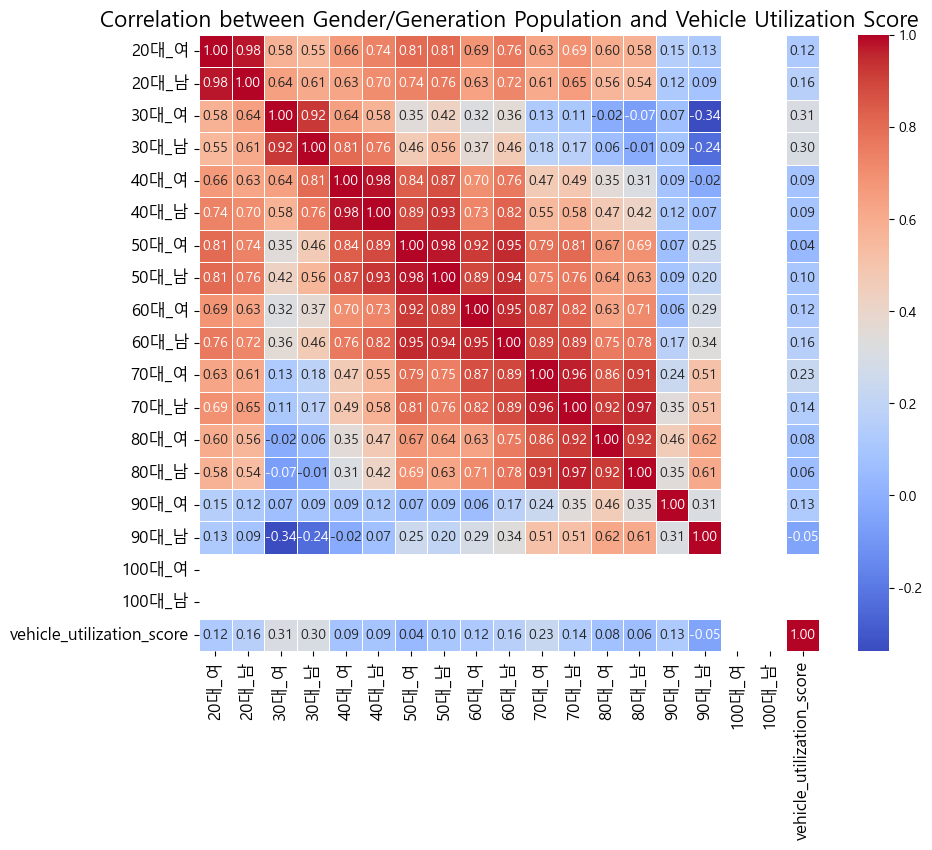

vehicle_utilization_score    1.000000
30대_여                        0.306739
30대_남                        0.303223
70대_여                        0.228150
20대_남                        0.162277
60대_남                        0.159335
70대_남                        0.142185
90대_여                        0.130496
20대_여                        0.120485
60대_여                        0.120162
50대_남                        0.102763
40대_남                        0.094803
40대_여                        0.089129
80대_여                        0.078386
80대_남                        0.057433
50대_여                        0.038784
90대_남                       -0.048499
100대_여                            NaN
100대_남                            NaN
Name: vehicle_utilization_score, dtype: float64

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract relevant columns: gender/generation populations and vehicle utilization score
relevant_columns = list(population_totals_df.columns) + ['vehicle_utilization_score']
correlation_data = joined_gdf[relevant_columns]

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))  # 그림 크기 조정
sns.heatmap(
    correlation_matrix,
    annot=True,
    annot_kws={"size": 10},  # 글꼴 크기 조정
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    cbar=True
)
plt.title("Correlation between Gender/Generation Population and Vehicle Utilization Score", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Display the correlation values for vehicle_utilization_score
vehicle_correlation = correlation_matrix['vehicle_utilization_score'].sort_values(ascending=False)
vehicle_correlation


##### 300m 내 유동인구

In [139]:
complete_data = complete_data[complete_data['year'] == 2023]
joined_gdf['buffer_300m'] = joined_gdf['geometry'].apply(lambda geom: geom.buffer(0.003))
# Define floating_columns to include relevant columns for floating population
floating_columns = complete_data.columns[2:-2]

# Function to calculate floating population by gender and generation within a buffer
def calculate_floating_population(buffer_geom, floating_data):
    totals = {col: 0 for col in floating_columns}
    for geom, row in floating_data:
        if buffer_geom.intersects(geom):
            for col in floating_columns:
                totals[col] += row[col]
    return totals

# Prepare floating_pop data for processing
floating_pop_data = list(zip(complete_data['geometry'], complete_data[floating_columns].to_dict(orient="records")))

# Calculate floating population for each buffer in sharehouse_car
joined_gdf['floating_population_totals'] = joined_gdf['geometry'].apply(
    lambda buffer_geom: calculate_floating_population(buffer_geom, floating_pop_data)
)

# Expand the floating population totals into separate columns
floating_totals_df = pd.DataFrame(joined_gdf['floating_population_totals'].tolist(), index=joined_gdf.index)
joined_gdf = pd.concat([joined_gdf, floating_totals_df], axis=1)

# Drop helper columns for clarity
joined_gdf.drop(columns=['floating_population_totals'], inplace=True)


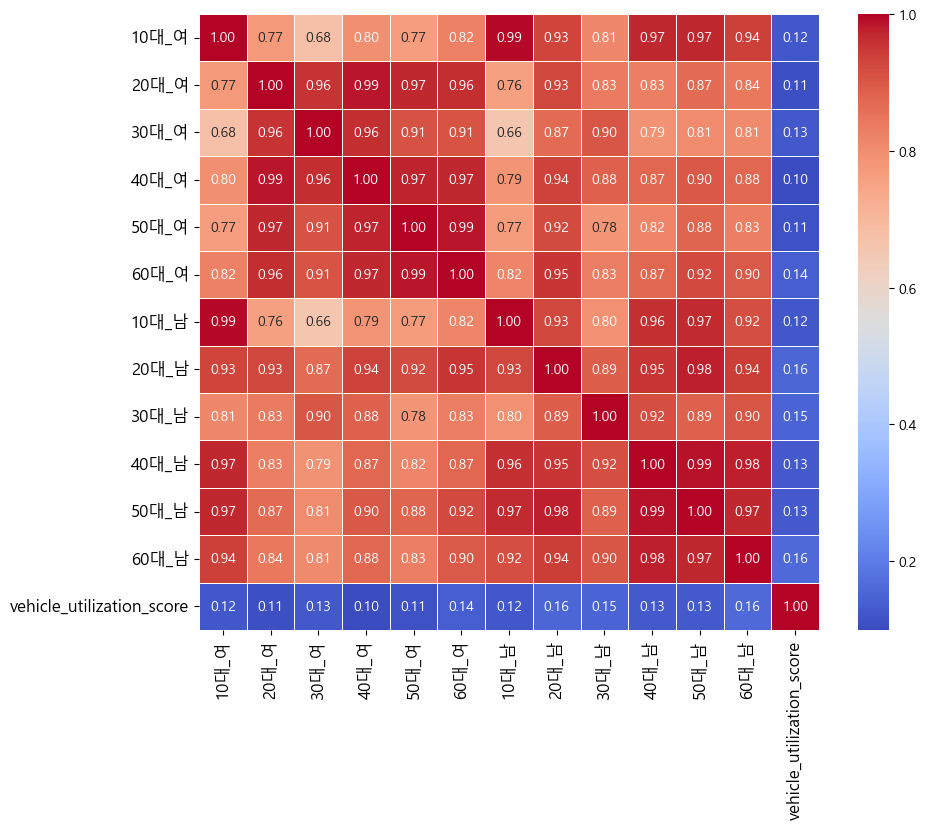

vehicle_utilization_score    1.000000
60대_남                        0.159268
20대_남                        0.155555
30대_남                        0.149428
60대_여                        0.135155
50대_남                        0.130557
40대_남                        0.129531
30대_여                        0.125749
10대_남                        0.123658
10대_여                        0.123170
50대_여                        0.112387
20대_여                        0.107459
40대_여                        0.099312
Name: vehicle_utilization_score, dtype: float64

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extract relevant columns: gender/generation populations and vehicle utilization score
relevant_columns = list(floating_columns) + ['vehicle_utilization_score']
correlation_data = joined_gdf[relevant_columns]

# Calculate correlation matrix
correlation_matrix = correlation_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))  # 그림 크기 조정
sns.heatmap(
    correlation_matrix,
    annot=True,
    annot_kws={"size": 10},  # 글꼴 크기 조정
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    cbar=True
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Display the correlation values for vehicle_utilization_score
vehicle_correlation = correlation_matrix['vehicle_utilization_score'].sort_values(ascending=False)
vehicle_correlation


#### 모델 학습 준비

In [ ]:
# 인구적 특성
# 94번째부터 111번째 열 제목에 "거주인구_" 추가
joined_gdf.columns = [
    f"거주인구_{col}" if 94 <= i <= 111 else col
    for i, col in enumerate(joined_gdf.columns)
]

# 113번째부터 124번째 열 제목에 "유동인구_" 추가
joined_gdf.columns = [
    f"유동인구_{col}" if 113 <= i <= 124 else col
    for i, col in enumerate(joined_gdf.columns)
]

In [153]:

respop_lst = [f"{col}" for i, col in enumerate(joined_gdf.columns) if 94 <= i <= 111]
floatpop_lst = ['유동인구_10대_여','유동인구_10대_남','유동인구_20대_여','유동인구_20대_남','유동인구_30대_여','유동인구_30대_남','유동인구_40대_여','유동인구_40대_남','유동인구_50대_여','유동인구_50대_남','유동인구_60대_여','유동인구_60대_남']

property1_df = joined_gdf[['blck_cd', 'type', 'noh', 'total_cnt', 'total_tm', 'car_cnt', 'vehicle_utilization_score'] + respop_lst + floatpop_lst]

In [154]:
property1_df.to_csv('property1_df.csv', index=False)